In [1]:
import logging
import os
from pprint import pprint

import dask.dataframe as dd
import numpy as np
import pandas as pd
import scipy.stats
from cloudpathlib import AnyPath as Path

In [2]:
import warnings

# with warnings.catch_warnings():
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
handler = logging.StreamHandler()
formatter = logging.Formatter(
    "%(asctime)s %(process)d/%(threadName)s %(name)s %(levelname)s - %(message)s"
)
handler.setFormatter(formatter)
logging.getLogger().handlers = [handler]

In [4]:
logger = logging.getLogger(__name__)

In [5]:
logging.getLogger(__name__).setLevel("DEBUG")
logging.getLogger("dask").setLevel("INFO")
logging.getLogger("gcsfs").setLevel("INFO")
logging.getLogger("google.cloud.bigquery").setLevel("DEBUG")
logging.getLogger("pandas").setLevel("DEBUG")
logging.getLogger("pyarrow").setLevel("DEBUG")

In [6]:
!gsutil ls gs://liulab/data/pseudobulk_optimization

gs://liulab/data/pseudobulk_optimization/1_no_qc_subset/
gs://liulab/data/pseudobulk_optimization/2_no_qc/
gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/


In [7]:
uri_pseudobulks = "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures"

# !gsutil ls -lhR {uri_pseudobulks} | grep data.parquet | head

In [8]:
pseudobulks = dd.read_parquet(uri_pseudobulks, engine="pyarrow")

In [9]:
pseudobulks = pseudobulks.replace(
    {"malignant_from_one_sample": {"True": True, "False": False}}
)

In [10]:
pseudobulks = pseudobulks.astype(
    {"n_cells": "uint8", "malignant_from_one_sample": "bool"}
)

In [11]:
uri_real_bulks = "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet"
real_bulks = dd.read_parquet(uri_real_bulks, engine="pyarrow")

In [12]:
merged = dd.merge(
    pseudobulks,
    real_bulks,
    how="inner",
    left_on=["gene_symbol", "tcga_aliquot_barcode_for_fractions"],
    right_on=["gene_symbol", "aliquot_barcode"],
    suffixes=["_pseudo", "_real"],
)

In [13]:
merged_groupby = merged.groupby(["n_cells", "malignant_from_one_sample"])

# correlations with real bulk

In [14]:
def compute_comparison_metrics(df: pd.DataFrame) -> pd.Series:
    logger.debug(f"computing metrics for {len(df)} length DataFrame")
    gene_means = df.groupby("gene_symbol")[["tpm_pseudo", "tpm_real"]].mean()
    ks_test_results = scipy.stats.ks_2samp(
        gene_means["tpm_pseudo"], gene_means["tpm_real"]
    )
    return pd.Series(
        {
            "corr_linear": np.corrcoef(df["tpm_pseudo"], df["tpm_real"])[0, 1],
            "corr_rank": scipy.stats.spearmanr(df["tpm_pseudo"], df["tpm_real"])[0],
            "ks_test_stat": ks_test_results[0],
            # "ks_test_pval_neg_log10": -np.log10(ks_test_results[1]),
        }
    )


metadata = [
    ("corr_linear", "float64"),
    ("corr_rank", "float64"),
    ("ks_test_stat", "float64"),
    # ("ks_test_pval_neg_log10", "float64"),
]
results = (
    merged_groupby.apply(compute_comparison_metrics, meta=metadata).dropna().compute()
)
results = results.sort_index()

2022-06-21 18:34:01,030 7135/ThreadPoolExecutor-0_6 __main__ DEBUG - computing metrics for 0 length DataFrame
2022-06-21 18:34:01,305 7135/ThreadPoolExecutor-0_9 __main__ DEBUG - computing metrics for 0 length DataFrame
2022-06-21 18:34:01,308 7135/ThreadPoolExecutor-0_1 __main__ DEBUG - computing metrics for 0 length DataFrame
2022-06-21 18:34:02,131 7135/ThreadPoolExecutor-0_15 __main__ DEBUG - computing metrics for 0 length DataFrame
2022-06-21 18:34:03,218 7135/ThreadPoolExecutor-0_4 __main__ DEBUG - computing metrics for 0 length DataFrame
2022-06-21 18:34:04,480 7135/ThreadPoolExecutor-0_2 __main__ DEBUG - computing metrics for 5911184 length DataFrame
2022-06-21 18:34:04,874 7135/ThreadPoolExecutor-0_5 __main__ DEBUG - computing metrics for 5911184 length DataFrame
2022-06-21 18:34:04,904 7135/ThreadPoolExecutor-0_8 __main__ DEBUG - computing metrics for 5911184 length DataFrame
2022-06-21 18:34:05,287 7135/ThreadPoolExecutor-0_15 __main__ DEBUG - computing metrics for 0 length 

In [15]:
results

corr_linear  corr_rank  ks_test_stat
n_cells malignant_from_one_sample                                      
1       False                         0.383704   0.544129      0.200710
        True                          0.378659   0.534210      0.193177
2       False                         0.446064   0.626017      0.199651
        True                          0.433748   0.612481      0.188196
3       False                         0.469585   0.660385      0.201457
        True                          0.453190   0.642836      0.191434
4       False                         0.485738   0.680212      0.200087
        True                          0.464210   0.657019      0.191434
5       False                         0.493848   0.692945      0.200710
        True                          0.471267   0.673449      0.191620
6       False                         0.500513   0.707899      0.201830
        True                          0.477952   0.681837      0.194795
7       False                         0.506996   0.715475      0.200959
        True                          0.482552   0.686683      0.193737
8       False                         0.509450   0.721801      0.201644
        True                          0.482761   0.693391      0.193862
9       False                         0.513871   0.725344      0.200212
        True                          0.484999   0.696503      0.194173
10      False                         0.514892   0.731941      0.201270
        True                          0.487130   0.702907      0.193177
11      False                         0.516902   0.735218      0.199963
        True                          0.491769   0.704959      0.197223
12      False                         0.518443   0.739676      0.201083
        True                          0.490717   0.707081      0.193613
13      False                         0.520759   0.743257      0.200585
        True                          0.492448   0.705129      0.190438
14      False                         0.520734   0.745216      0.200647
        True                          0.490921   0.711121      0.196539
15      False                         0.523550   0.748091      0.199963
        True                          0.497184   0.716650      0.195916
16      False                         0.524378   0.749220      0.200336
        True                          0.496080   0.717973      0.195231
17      False                         0.525168   0.750804      0.200896
        True                          0.497385   0.715271      0.196103
18      False                         0.524398   0.753291      0.201332
        True                          0.497995   0.714142      0.193924
19      False                         0.526712   0.755120      0.200523
        True                          0.496763   0.715737      0.190873
20      False                         0.527814   0.756311      0.200710
        True                          0.498421   0.717892      0.192181

In [16]:
import plotly.express as px
import plotly.graph_objects as go

2022-06-21 18:49:21,167 7135/MainThread __main__ DEBUG - adding trace: corr_rank, malignants ~ all samples
2022-06-21 18:49:21,171 7135/MainThread __main__ DEBUG - adding trace: corr_rank, malignants ~ one sample
2022-06-21 18:49:21,174 7135/MainThread __main__ DEBUG - adding trace: corr_linear, malignants ~ all samples
2022-06-21 18:49:21,177 7135/MainThread __main__ DEBUG - adding trace: corr_linear, malignants ~ one sample


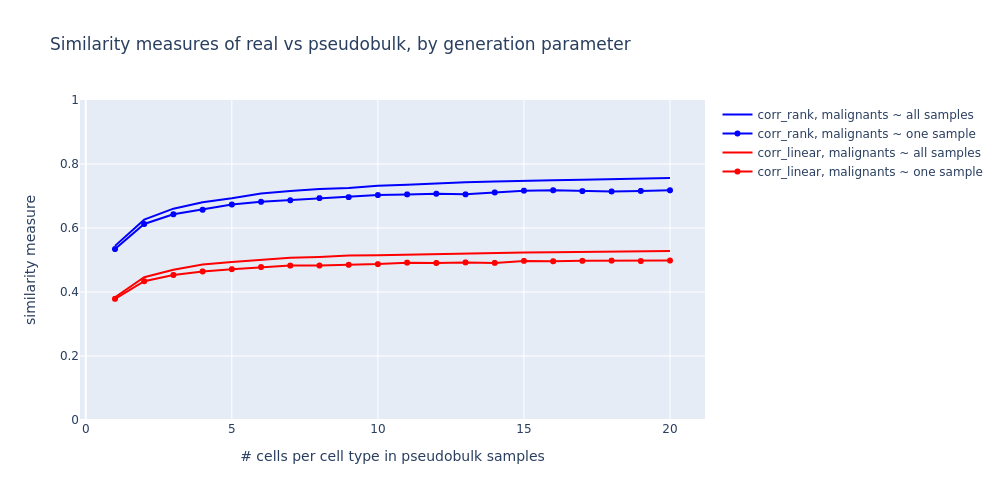

In [18]:
fig = go.Figure()
modes = {True: "lines+markers", False: "lines"}
for column, color in zip(results.columns[[1, 0]], ["blue", "red"]):
    for malignant_from_one_sample in results.index.unique(
        level="malignant_from_one_sample"
    ):
        malignant_label = "one sample" if malignant_from_one_sample else "all samples"
        trace_name = f"{column}, malignants ~ {malignant_label}"
        subset = (
            results.query(f"malignant_from_one_sample == {malignant_from_one_sample}")
            .sort_index()
            .reset_index()
        )
        logger.debug(f"adding trace: {trace_name}")
        fig.add_trace(
            go.Scatter(
                x=subset["n_cells"],
                y=subset[column],
                mode=modes[malignant_from_one_sample],
                name=trace_name,
                line_color=color,
            )
        )
fig.update_layout(
    title="Similarity measures of real vs pseudobulk, by generation parameter"
)
fig = fig.update_yaxes(range=[0, 1], title="similarity measure")
fig = fig.update_xaxes(title="# cells per cell type in pseudobulk samples")

fig.show(width=1000, renderer="png")
# fig

# inter-sample correlation

what's the inter-sample correlation of tcga skcm?

In [ ]:
df_real_bulks = real_bulks.compute()

In [ ]:
z = df_real_bulks.pivot(
    index="gene_symbol",
    columns="aliquot_barcode",
    values="tpm",
).corr()
zz = z.values.flatten()
zzz = zz[: -len(z)]
np.median(zzz), np.mean(zzz), np.std(zzz)

How does inter-sample correlation decrease with more n_cells?

In [19]:
def compute_intersample_metrics(df):
    z = df.pivot(
        index="gene_symbol",
        columns="tcga_aliquot_barcode_for_fractions",
        values="tpm_pseudo",
    ).corr()
    zz = z.values.flatten()
    zzz = zz[: -len(z)]
    return pd.Series(
        {
            "intersample_corr_median": np.median(zzz),
            "intersample_corr_mean": np.mean(zzz),
            "intersample_corr_stddev": np.std(zzz),
        }
    )


metadata = [
    ("intersample_corr_median", "float64"),
    ("intersample_corr_mean", "float64"),
    ("intersample_corr_stddev", "float64"),
]
results_intersample = (
    merged_groupby.apply(compute_intersample_metrics, meta=metadata).dropna().compute()
)
results_intersample = results_intersample.sort_index()

In [ ]:
results_intersample

# ended here!

In [ ]:
results_intersample.set_index(
    results_intersample.index.map(lambda x: (x[0], f"malignant_from_one_sample={x[1]}"))
).unstack(level=-1)

In [ ]:
_ = results_intersample.unstack(level="malignant_from_one_sample")
# _.columns = _.columns.to_flat_index().map(lambda x: f"{x[0]}={x[1]}")
_.columns.map(lambda x: f"malignant_from_one_sample={x}")

In [ ]:
_ = results_intersample.unstack(level="malignant_from_one_sample")
_.columns = _.columns.get_level_values(1)
_

px.line(_)

# appendix 1

In [ ]:
merged.dtypes

In [ ]:
x = merged.query("n_cells == 5 and malignant_from_one_sample")[
    ["gene_symbol", "tcga_aliquot_barcode_for_fractions", "tpm_pseudo"]
]

In [ ]:
y = x.compute()

In [ ]:
y.info()

In [ ]:
z = y.pivot(
    index="gene_symbol",
    columns="tcga_aliquot_barcode_for_fractions",
    values="tpm_pseudo",
).corr()

In [ ]:
z.shape

In [ ]:
zz = z.values.flatten()

In [ ]:
zz.shape

In [ ]:
zz.sort()

In [ ]:
zzz = zz[: -len(z)]

In [ ]:
zzz.shape

In [ ]:
np.median(zzz)